

### **Text Cell**

# Day 2: TensorFlow Basics & The Limits of MLPs

**Welcome to Day 2\!**

Yesterday, we built a Multi-Layer Perceptron (MLP) that performed *great* on the simple MNIST dataset.

**Today's Plan:**

1.  **TensorFlow Basics:** Learn how to load a custom dataset of *color images* from folders using `tf.keras.utils`.
2.  **The Challenge:** We'll use our Day 1 "multilayer ANN" (MLP) knowledge to classify "Fresh vs. Rotten Fruit."
3.  **Backpropagation:** We'll train the model, which relies on this "backpropagation" concept to learn.
4.  **Analyze:** We will (intentionally) see this model struggle and discuss *why*. This sets us up for the second half of today's lesson.

-----

### **Text Cell**

## Cell 1: Setup - Importing Libraries

Let's import our standard libraries. We'll add `os` to help us check our file paths.

-----

### **Code Cell**

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

print(f"TensorFlow Version: {tf.__version__}")
print("Libraries imported.")

TensorFlow Version: 2.19.0
Libraries imported.


-----

### **Text Cell**

## Cell 2: Define Dataset Parameters

We need to set some global parameters for our model, like the image size we want to use and the batch size for training.

-----

### **Code Cell**

In [2]:
# We will resize all images to 64x64
IMG_SIZE = 64
print(f"Image size set to: {IMG_SIZE}x{IMG_SIZE} pixels")

# We will train in batches of 32 images at a time
BATCH_SIZE = 32
print(f"Batch size set to: {BATCH_SIZE}")

# Our images have 3 color channels (R, G, B)
CHANNELS = 3
print(f"Number of color channels: {CHANNELS}")

# Our dataset has 6 classes
NUM_CLASSES = 6
print(f"Number of classes: {NUM_CLASSES}")

Image size set to: 64x64 pixels
Batch size set to: 32
Number of color channels: 3
Number of classes: 6


-----

### **Text Cell**

## Cell 3: Define File Paths

Let's define the paths to our `train` and `test` directories from the dataset you downloaded.

**IMPORTANT:** This code assumes you have downloaded and unzipped the "Fresh and Rotten Fruits" dataset into a folder named `dataset` in the same directory as this notebook. (In Colab, you may need to upload it or mount your Google Drive).

-----

### **Code Cell**

In [4]:
# =============================================
# Execute this code only when you Dont have dataset || prefer when you are executing this in Google colab
# ==============================================
# Download the dataset from Kaggle using kagglehub

import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sriramr/fruits-fresh-and-rotten-for-classification")

print("Path to dataset files:", path)

# The downloaded dataset structure is typically dataset/train and dataset/test
# Adjust the base_dir to point to the extracted dataset folder
base_dir = os.path.join(path, "dataset")

print(f"Base directory: {base_dir}")
print("Exists:", os.path.exists(base_dir))


# Training data path
train_dir = os.path.join(base_dir, "train")
print(f"Training data path: {train_dir}")
print("Exists:", os.path.exists(train_dir))

# Test data path
test_dir = os.path.join(base_dir, "test")
print(f"Test data path: {test_dir}")
print("Exists:", os.path.exists(test_dir))

100%|██████████| 3.58G/3.58G [00:31<00:00, 121MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1
Base directory: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset
Exists: True
Training data path: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset/train
Exists: True
Test data path: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset/test
Exists: True


-----

### **Text Cell**

## Cell 4: Load Training Data (TensorFlow Basics)

This is a key "TensorFlow Basic." We're not loading a built-in dataset. We're loading from folders.

We use `image_dataset_from_directory` to do this. It's amazing\! It automatically:

1.  Finds all the subfolders (e.g., `fresh_apple`) and uses them as class labels.
2.  Resizes all images to our `IMG_SIZE`.
3.  Creates batches of `BATCH_SIZE`.
4.  Converts labels to `categorical` (one-hot encoding) because we have 6 classes.

-----

### **Code Cell**

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

print("\nLoaded Training Data.")
print(f"Found {train_dataset.cardinality().numpy() * BATCH_SIZE} total images in {len(train_dataset.class_names)} classes.")
print("Note: The 'class names' are the folder names.")

Found 10901 files belonging to 6 classes.

Loaded Training Data.
Found 10912 total images in 6 classes.
Note: The 'class names' are the folder names.


-----

### **Text Cell**

## Cell 5: Load Validation/Test Data

Now we do the exact same thing for our test (validation) data.

-----

### **Code Cell**

In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

print("\nLoaded Validation (Test) Data.")
print(f"Found {validation_dataset.cardinality().numpy() * BATCH_SIZE} total images in {len(validation_dataset.class_names)} classes.")

Found 2698 files belonging to 6 classes.

Loaded Validation (Test) Data.
Found 2720 total images in 6 classes.


-----

### **Text Cell**

## Cell 6: Inspect the Class Names

Let's see the classes that the loader found. The order in this list is the order the model will use (e.g., 0 = fresh\_apple, 1 = fresh\_banana, etc.).

-----

### **Code Cell**

In [7]:
class_names = train_dataset.class_names
print("The 6 classes found are:")
for i, name in enumerate(class_names):
    print(f"  Index {i}: {name}")

The 6 classes found are:
  Index 0: freshapples
  Index 1: freshbanana
  Index 2: freshoranges
  Index 3: rottenapples
  Index 4: rottenbanana
  Index 5: rottenoranges


-----

### **Text Cell**

## Cell 7: Check Data Shapes

Let's pull one batch from our `train_dataset` and check the *shape* of the images and labels. This is critical for debugging.

-----

### **Code Cell**

In [8]:
# .take(1) grabs a single batch from the dataset
# We use a loop to "iterate" over this single batch
for images, labels in train_dataset.take(1):
    print("Pulled one batch from the training dataset.")
    images_batch_shape = images.shape
    labels_batch_shape = labels.shape

# Now let's inspect the shapes
print(f"Images batch shape: {images_batch_shape}")
print(f"Labels batch shape: {labels_batch_shape}")

Pulled one batch from the training dataset.
Images batch shape: (32, 64, 64, 3)
Labels batch shape: (32, 6)


-----

### **Text Cell**

**What does this mean?**

  * `Images batch shape: (32, 64, 64, 3)`: We have a batch of **32** images, each is **64**x**64** pixels, with **3** color channels (R,G,B).
  * `Labels batch shape: (32, 6)`: We have **32** labels, and each label is a **6**-element array (one-hot encoded).

For example, `fresh_banana` (index 1) would be: `[0, 1, 0, 0, 0, 0]`

-----

### **Text Cell**

### Cell 7b: Example of a One-Hot Encoded Label

Let's look at the label for the *first* image in this batch and see what one-hot encoding means.

-----

### **Code Cell**

In [9]:
# Get the first label from the batch
# (We need to grab the 'labels' variable from the cell above)
first_label_encoded = labels[0]
print(f"One-hot encoded label for the first image:\n {first_label_encoded}")

# Use np.argmax() to find the index of the '1'
first_label_index = np.argmax(first_label_encoded)
print(f"\nThe index with the '1' is: {first_label_index}")

# Now map this index back to the class name
first_label_name = class_names[first_label_index]
print(f"\nThis corresponds to the class: '{first_label_name}'")

One-hot encoded label for the first image:
 [0. 0. 0. 0. 1. 0.]

The index with the '1' is: 4

This corresponds to the class: 'rottenbanana'


-----

### **Text Cell**

## Cell 8: Visualize the Data

Let's see what we're working with\! We'll plot the first 9 images from a single batch.

-----

### **Code Cell**

Preparing to plot the first 9 images...
Displaying one batch of 9 images from the training set.


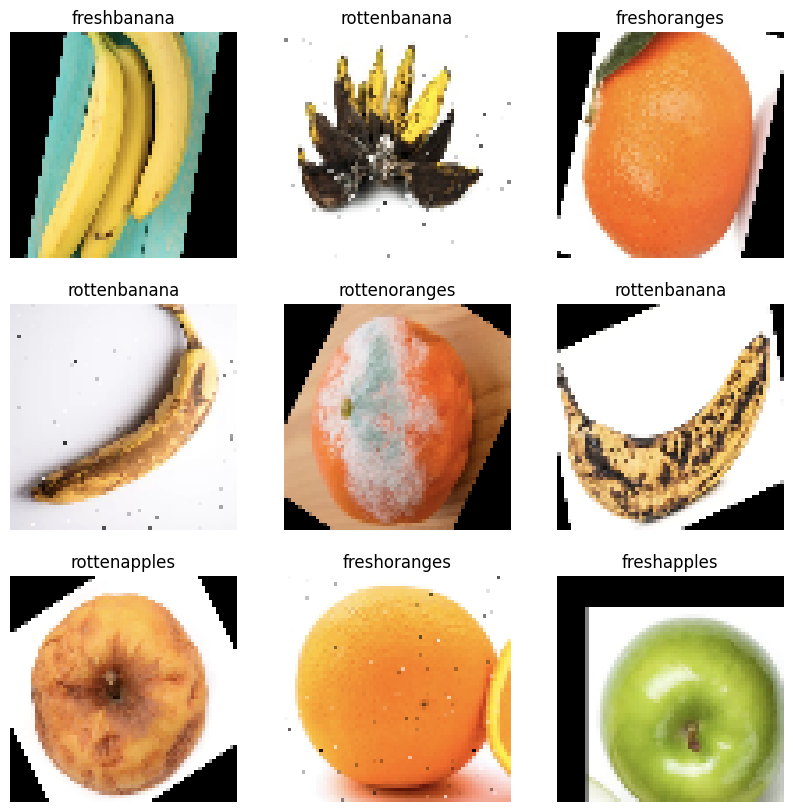

In [10]:
plt.figure(figsize=(10, 10))
print("Preparing to plot the first 9 images...")

# We need to grab one batch *again* as the generator is now empty
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Images are loaded as floats, we convert to integers for display
        plt.imshow(images[i].numpy().astype("uint8"))

        # Find the index of the '1' in the one-hot encoded label
        class_index = np.argmax(labels[i])

        plt.title(class_names[class_index])
        plt.axis("off")

print("Displaying one batch of 9 images from the training set.")
plt.show()

-----

### **Text Cell**

## Cell 9: Configure Dataset for Performance

These are two more "TensorFlow Basics" that make training *much* faster.

  * `.cache()`: Keeps the images in memory after they're loaded.
  * `.prefetch()`: Pre-loads the *next* batch of images while the model is training on the *current* batch.

-----

### **Code Cell**

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
print(f"Set AUTOTUNE to: {AUTOTUNE}")

# Apply .cache() and .prefetch() to the training dataset
train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print("Applied .cache() and .prefetch() to training dataset.")

# Apply .cache() and .prefetch() to the validation dataset
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print("Applied .cache() and .prefetch() to validation dataset.")

Set AUTOTUNE to: -1
Applied .cache() and .prefetch() to training dataset.
Applied .cache() and .prefetch() to validation dataset.


-----

### **Text Cell**

## Cell 10: Build the Multi-Layer ANN (MLP)

Now, we'll build the *exact same kind* of model as Day 1.

1.  **Rescaling Layer:** First, we'll normalize pixels from `0-255` to `0-1`.
2.  **Flatten Layer:** This is the key. We will "unroll" the `64x64x3` image into a single, flat vector.
3.  **Dense (Hidden) Layers:** Two hidden layers with `relu` activation.
4.  **Dense (Output) Layer:** A final layer with 6 neurons (one for each class) and `softmax`.

-----

### **Text Cell**

### Cell 10a: Building the Model Architecture

We will define our `Sequential` model. Think of this as a stack of layers, one on top of the other.

  * **Input:** `(64, 64, 3)`
  * `Rescaling`: Normalizes pixels.
  * `Flatten`: Converts `(64, 64, 3)` -\> `(12288)`
  * `Dense`: Hidden layer 1 (128 neurons). Learns simple patterns.
  * `Dense`: Hidden layer 2 (64 neurons). Learns combinations of patterns.
  * `Dense`: Output layer (6 neurons). Makes the final decision.

-----

### **Code Cell**

In [12]:
model_mlp = tf.keras.Sequential([
    # 1. Rescale pixels
    tf.keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 2. Flatten the 64x64x3 image into a vector
    tf.keras.layers.Flatten(),

    # 3. Hidden layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),

    # 4. Output layer
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

print("MLP model built successfully.")
print("Architecture:")
print("  1. Rescaling (1./255)")
print("  2. Flatten")
print("  3. Dense (128 units, relu)")
print("  4. Dense (64 units, relu)")
print("  5. Dense (6 units, softmax)")

MLP model built successfully.
Architecture:
  1. Rescaling (1./255)
  2. Flatten
  3. Dense (128 units, relu)
  4. Dense (64 units, relu)
  5. Dense (6 units, softmax)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


-----

### **Text Cell**

## Cell 11: Model Summary - The "Gotcha"

Let's look at the summary. Pay *very* close attention to the number of parameters.

-----

### **Code Cell**

In [13]:
model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,638 (6.03 MB)

 Trainable params: 1,581,638 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

-----

### **Text Cell**

**Analyze This\!**

  * The `flatten` layer output is `12288` (which is `64 * 64 * 3`).
  * The first `dense` layer has **1,573,000** parameters\!

**Why?** Because every *single* one of the 12,288 pixels needs to be connected to *every* one of the 128 neurons. `(12288 * 128) + 128 = 1,573,000`.

This is a **massive** network. It's very likely to overfit and will be slow to train.

-----

### **Text Cell**

## Cell 12: Compile the Model

Let's compile the model.

  * **Loss:** `categorical_crossentropy` is correct because our labels are one-hot encoded (e.g., `[0, 1, 0, 0, 0, 0]`).
  * **Optimizer:** `adam` is a great default.

-----

### **Code Cell**

In [14]:
model_mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("MLP model compiled.")
print(f"  Optimizer: adam")
print(f"  Loss: categorical_crossentropy")
print(f"  Metrics: ['accuracy']")

MLP model compiled.
  Optimizer: adam
  Loss: categorical_crossentropy
  Metrics: ['accuracy']


-----

### **Text Cell**

## Cell 13: What is Backpropagation? (Text)

Before we train, let's talk about the "Backpropagation" from the syllabus.

When we call `model.fit()`, a 4-step cycle happens for every batch:

1.  **Forward Pass:** A batch of images flows *forward* through the network, and the model makes a (bad) prediction.
2.  **Loss Calculation:** The `loss` function (`categorical_crossentropy`) compares the bad prediction to the *true* label and calculates an "error" or "loss" score.
3.  **Backward Pass (Backpropagation):** This is the magic. TensorFlow calculates the *gradient* (think: "blame") for the loss with respect to *every single weight* in the network. It uses the chain rule to "propagate" this error *backward* from the output layer to the input layer.
4.  **Optimization:** The `adam` optimizer gets this "blame" report (the gradients) and "nudges" every weight *just a little bit* in the direction that will reduce the loss.

This cycle repeats thousands of times. That's "training."

-----

### **Code Cell**

In [15]:
print("Theory cell complete. Ready to train.")

Theory cell complete. Ready to train.


-----

### **Text Cell**

## Cell 14: Train the Model

Now, let's train our giant MLP. We'll train for 10 epochs and see what happens.

`validation_data=val_ds` tells the model to check its performance on the unseen test data after every epoch.

-----

### **Code Cell**

In [16]:
print("Starting MLP model training for 10 epochs...")
# We'll save the history to plot it later
history_mlp = model_mlp.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    verbose=1 # Show progress
)

print("\nMLP training complete.")

Starting MLP model training for 10 epochs...
Epoch 1/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - accuracy: 0.4430 - loss: 1.7255 - val_accuracy: 0.6542 - val_loss: 0.9039
Epoch 2/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.6540 - loss: 0.9032 - val_accuracy: 0.7198 - val_loss: 0.7565
Epoch 3/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7267 - loss: 0.7203 - val_accuracy: 0.7987 - val_loss: 0.5589
Epoch 4/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7766 - loss: 0.6124 - val_accuracy: 0.8084 - val_loss: 0.5203
Epoch 5/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8046 - loss: 0.5356 - val_accuracy: 0.8217 - val_loss: 0.4870
Epoch 6/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.8211 - loss: 0.4893 - val_accuracy: 0.8254 - val_loss: 0.4724
Epoch 7/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8302 - loss: 0.4633 - val_accuracy: 0.8288 - val_loss: 0.4606
Epoch 8/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 29

-----

### **Text Cell**

## Cell 15: Prepare to Visualize Training

The `history_mlp` object contains all the data from training. To make it easy to plot, we'll convert it to a `pandas.DataFrame`.

-----

### **Code Cell**

In [19]:
# We need pandas for this
import pandas as pd
history_df = pd.DataFrame(history_mlp.history)

print("Training history converted to DataFrame. First 5 epochs:")
print(history_df)

Training history converted to DataFrame. First 5 epochs:
   accuracy      loss  val_accuracy  val_loss
0  0.548207  1.248460      0.654188  0.903934
1  0.667370  0.884371      0.719792  0.756495
2  0.745895  0.684126      0.798740  0.558926
3  0.788368  0.579377      0.808377  0.520276
4  0.810476  0.518731      0.821720  0.486975
5  0.822769  0.480308      0.825426  0.472358
6  0.833777  0.452533      0.828762  0.460585
7  0.842492  0.431319      0.811342  0.492703
8  0.844693  0.421036      0.784655  0.554159
9  0.841391  0.423356      0.807265  0.501405


-----

### **Text Cell**

### Cell 15b: Visualize Training History (Loss)

Let's plot the "loss" (error).

  * `loss`: The model's error on the training data.
  * `val_loss`: The model's error on the *unseen* validation data.

-----

### **Code Cell**

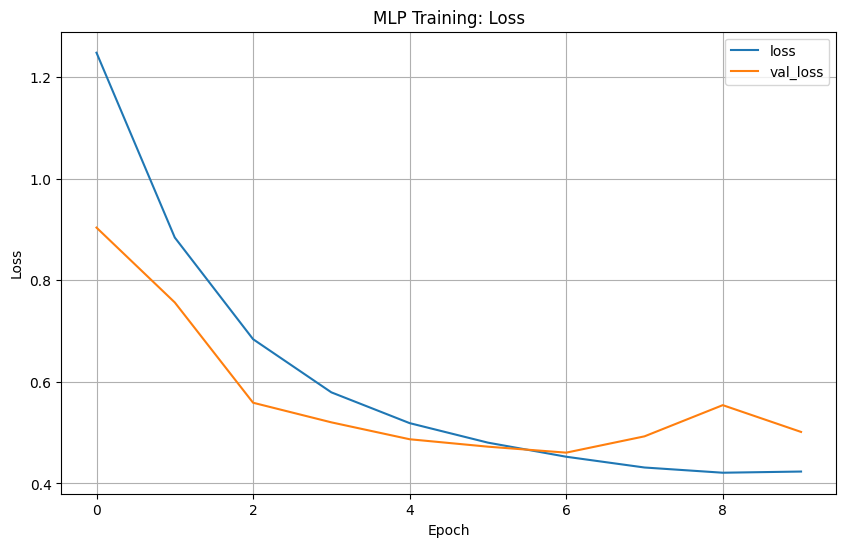

Loss plot displayed.


In [20]:
history_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title("MLP Training: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("Loss plot displayed.")

-----

### **Text Cell**

## Cell 16: Visualize Training History (Accuracy)

Now let's plot the "accuracy."

  * `accuracy`: The model's accuracy on the training data.
  * `val_accuracy`: The model's accuracy on the *unseen* validation data.

-----

### **Code Cell**

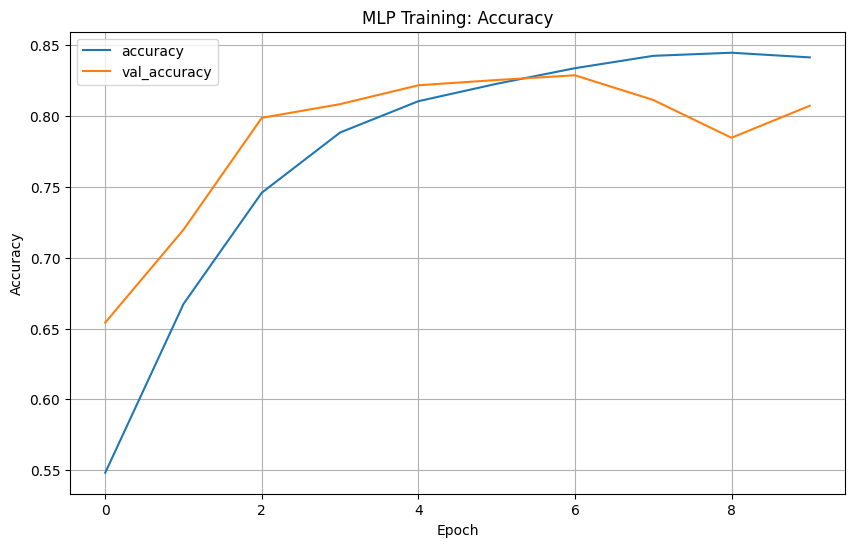

Accuracy plot displayed.


In [21]:
history_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.title("MLP Training: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print("Accuracy plot displayed.")

-----

### **Text Cell**

## Cell 17: Analyze the Results (The Failure)

Look at your plots. You will see:

1.  **High Training Accuracy:** The `accuracy` line (blue) probably went up to 90-100%. The model *memorized* the training data.
2.  **Low/Stagnant Validation Accuracy:** The `val_accuracy` (orange) line is the *real* test. It probably got stuck at a low value (e.g., 50-70%) and may even go *down*.
3.  **Diverging Loss:** The `val_loss` (orange loss) probably shot *up* while the `loss` (blue loss) went down.

This is a classic case of **massive overfitting**.

-----

### **Code Cell**

In [22]:
# Let's get the final, best validation accuracy
final_acc = max(history_mlp.history['val_accuracy'])
print(f"The best validation accuracy our MLP achieved was: {final_acc * 100:.2f}%")

The best validation accuracy our MLP achieved was: 82.88%


##Cell: Visualizing Model (CNN) Predictions
Now for the final test you asked for! Let's take random images from our validation (test) set and see what our new CNN model predicted.

We'll use the same Green (Correct) / Red (Incorrect) system. With ~96% accuracy, we should expect to see almost all green.

Making predictions with model_cnn on a batch of validation images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Plotting CNN prediction grid...


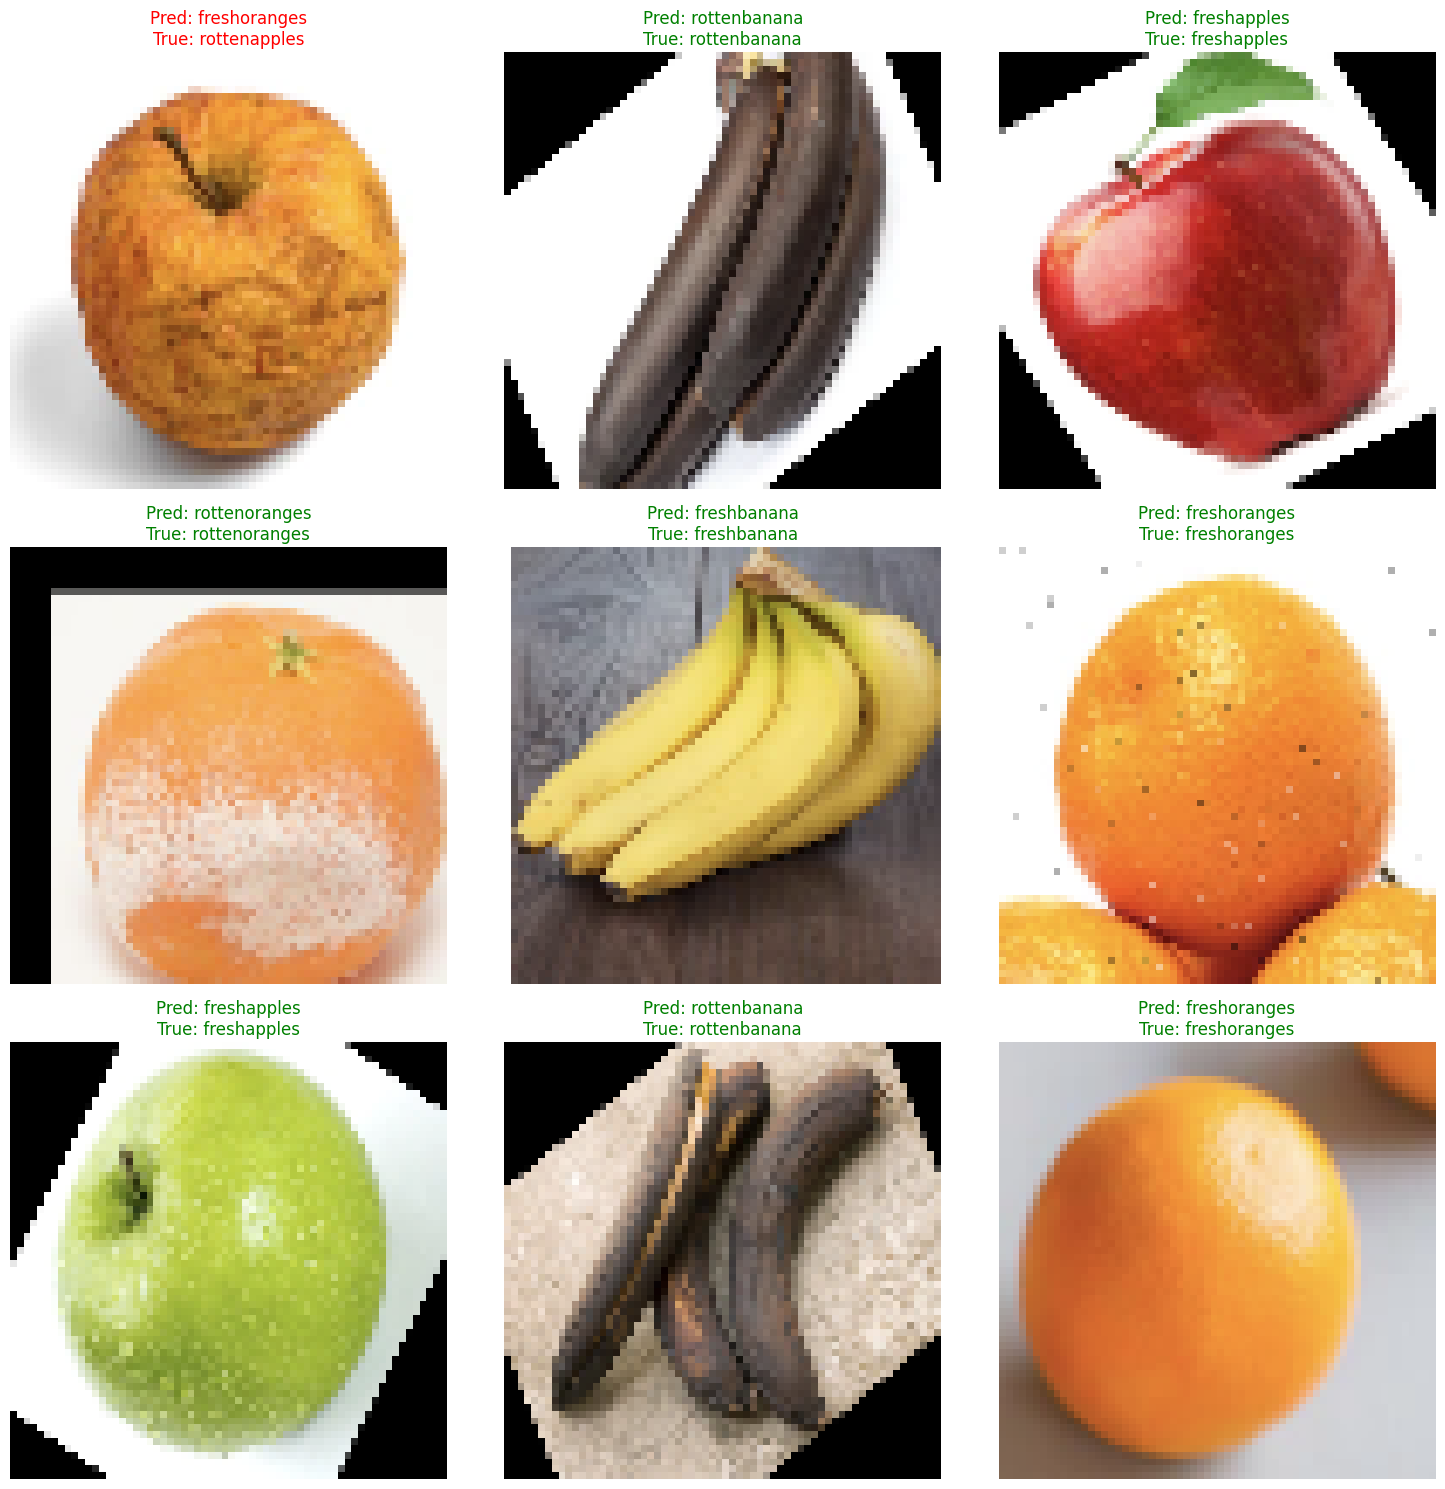

In [23]:
# Get one batch of images and labels from the validation set
# We use next(iter(...)) to grab a single batch
images_batch, labels_batch = next(iter(val_ds))

# Make predictions on this batch using the CNN
print("Making predictions with model_cnn on a batch of validation images...")
predictions_batch = model_mlp.predict(images_batch)

# Get the predicted class indices
predicted_indices = np.argmax(predictions_batch, axis=1)
# Get the true class indices
true_indices = np.argmax(labels_batch.numpy(), axis=1)

# --- Plot the results ---
plt.figure(figsize=(15, 15))
print("Plotting CNN prediction grid...")

# We'll plot the first 9 images in the batch
for i in range(9):
    plt.subplot(3, 3, i + 1)

    # Show the image
    plt.imshow(images_batch[i].numpy().astype("uint8"))

    # Get the predicted and true labels
    pred_label = class_names[predicted_indices[i]]
    true_label = class_names[true_indices[i]]

    # Set the color
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

-----

### **Text Cell**

## Day 2 (Part 1) Conclusion

**Why did our model fail so badly?**

Because we used a `Flatten` layer.

We took our `64x64x3` image and "unrolled" it into a `12,288` pixel-long vector. This **destroyed all spatial information**.

  * The model has no idea that one pixel is "above" or "next to" another.
  * It can't learn "features" like "a curved yellow edge" (a banana) or "a round red shape" (an apple).
  * It just sees 12,288 jumbled features, which led to a *massive* 1.5M+ parameter network that simply *memorized* the training set.

**Next Step:**

How do we fix this? We need a model that *understands* 2D space. A model that can look for features, patterns, and textures *within* the 2D image.

In the **second notebook for Day 2**, we will solve this exact same problem using a **Convolutional Neural Network (CNN)**.